<a href="https://colab.research.google.com/github/Davron030901/Data_Science/blob/main/Malaria2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Datasetni yuklash
(ds_train, ds_test), ds_info = tfds.load(
    'malaria',
    split=['train[:80%]', 'train[80%:]'], # Yoki 'train', 'test' agar alohida test split mavjud bo'lsa
                                         # Odatda 'train' ni o'zini train/validation ga bo'lamiz
    shuffle_files=True,
    as_supervised=True,  # (image, label) formatida qaytaradi
    with_info=True
)

# Validation set uchun trainning bir qismini ajratamiz
# Agar datasetda alohida validation split bo'lmasa:
TRAIN_SIZE = int(0.8 * ds_info.splits['train'].num_examples)
# VALIDATION_SIZE = ds_info.splits['train'].num_examples - TRAIN_SIZE # Agar yuqorida [:80%] [80%:] qilinmagan bo'lsa

# ds_train = ds_train.take(TRAIN_SIZE)
# ds_val = ds_info.splits['train'].skip(TRAIN_SIZE) # Bu yerda xatolik bo'lishi mumkin,
                                                   # yuqoridagi split=['train[:80%]', 'train[80%:]'] yaxshiroq

print(f"Dataset haqida ma'lumot: {ds_info}")
print(f"O'qitish to'plami elementlari soni: {tf.data.experimental.cardinality(ds_train).numpy()}")
print(f"Validatsiya/Test to'plami elementlari soni: {tf.data.experimental.cardinality(ds_test).numpy()}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.SR5E53_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
Dataset haqida ma'lumot: tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citat

In [ ]:
def normalize_img(image, label):
    """Piksel qiymatlarini [0,1] oralig'iga normallashtiradi."""
    return tf.cast(image, tf.float32) / 255.0, label

In [ ]:
IMG_SIZE = 128 # Yoki boshqa mos o'lcham
def resize_img(image, label):
    return tf.image.resize(image, (IMG_SIZE, IMG_SIZE)), label

In [ ]:
# TensorFlow Keras preprocessing layers yordamida
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

def augment_data(image, label):
    # Augmentatsiyani faqat o'qitish ma'lumotlariga qo'llang
    return data_augmentation(image, training=True), label

In [ ]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE # tf.data optimallashtirish uchun

def prepare_dataset(ds, shuffle=False, augment=False):
    ds = ds.map(resize_img, num_parallel_calls=AUTOTUNE)
    ds = ds.map(normalize_img, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=1000) # buffer_size ni dataset hajmiga moslang

    ds = ds.batch(BATCH_SIZE)

    if augment:
        ds = ds.map(augment_data, num_parallel_calls=AUTOTUNE) # Augmentatsiyani batchdan keyin yoki oldin qilish mumkin

    return ds.prefetch(buffer_size=AUTOTUNE) # O'qitish vaqtida keyingi batchlarni tayyorlab turadi

train_dataset = prepare_dataset(ds_train, shuffle=True, augment=True)
val_dataset = prepare_dataset(ds_test) # Yoki ds_val agar alohida ajratilgan bo'lsa
# test_dataset uchun ham 'augment=False' bo'ladi

In [ ]:
# Misol: MobileNetV2 bilan transfer learning (TensorFlow/Keras)
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False, # Klassifikator qatlamisiz
                                               weights='imagenet')
base_model.trainable = False # Dastlabki bosqichda muzlatamiz

# Yangi klassifikator qo'shish
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid') # Ikkilik klassifikatsiya uchun

model_tl = tf.keras.Sequential([
    base_model,
    global_average_layer,
    tf.keras.layers.Dropout(0.2), # Regularizatsiya
    prediction_layer
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# TensorFlow/Keras da oddiy CNN
model_custom = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid') # Parazitlangan (1) yoki yo'q (0)
])

model_custom.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='binary_crossentropy', # Ikkilik klassifikatsiya
                     metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# PyTorch da ham shunga o'xshash model yaratish mumkin
# (PyTorch kodi biroz ko'proq "boilerplate" talab qiladi)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# PyTorch da oddiy CNN (strukturaviy misol)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader # PyTorch uchun DataLoader kerak bo'ladi

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        # Hisoblash kerak: 128 * (IMG_SIZE // 8) * (IMG_SIZE // 8)
        # Masalan, IMG_SIZE = 128 bo'lsa, 128 // 8 = 16. Shunda 128 * 16 * 16
        # O'lchamni to'g'ri hisoblash kerak yoki AdaptiveAvgPool2d dan foydalanish
        self.fc1_input_features = 128 * (IMG_SIZE // 8) * (IMG_SIZE // 8)
        self.fc1 = nn.Linear(self.fc1_input_features, 128)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid() # Ikkilik klassifikatsiya uchun

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x) # Agar loss funksiyasi BCEWithLogitsLoss bo'lsa, bu kerak emas
        return x

# PyTorch modelini o'qitish:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_pytorch = SimpleCNN(num_classes=1).to(device)
# criterion = nn.BCELoss() # Yoki nn.BCEWithLogitsLoss() agar oxirgi qatlamda sigmoid bo'lmasa
# optimizer = optim.Adam(model_pytorch.parameters(), lr=0.001)

# O'qitish sikli (training loop) yozish kerak bo'ladi

In [ ]:
# TensorFlow/Keras da
EPOCHS = 20 # Misol uchun, kerak bo'lsa oshiring
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Modelni saqlash uchun callback
# model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_malaria_model.h5', save_best_only=True, monitor='val_accuracy')

history = model_custom.fit( # Yoki model_tl
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping] #, model_checkpoint]
)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 823s 1s/step - accuracy: 0.7635 - loss: 0.5063 - precision: 0.7369 - recall: 0.8229 - val_accuracy: 0.9412 - val_loss: 0.1740 - val_precision: 0.9303 - val_recall: 0.9528
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 845s 1s/step - accuracy: 0.9435 - loss: 0.1815 - precision: 0.9278 - recall: 0.9630 - val_accuracy: 0.9525 - val_loss: 0.1531 - val_precision: 0.9315 - val_recall: 0.9758
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 826s 1s/step - accuracy: 0.9486 - loss: 0.1644 - precision: 0.9310 - recall: 0.9705 - val_accuracy: 0.9526 - val_loss: 0.1511 - val_precision: 0.9312 - val_recall: 0.9766
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 759s 1s/step - accuracy: 0.9520 - loss: 0.1596 - precision: 0.9385 - recall: 0.9682 - val_accuracy: 0.9546 - val_loss: 0.1438 - val_precision: 0.9410 - val_recall: 0.9693
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 760s 1s/step - accuracy: 0.9516 - loss: 0.1552 - precision: 0.9396 - recall: 0.9662 - val_accuracy: 0.9548 - val_los

173/173 ━━━━━━━━━━━━━━━━━━━━ 47s 268ms/step - accuracy: 0.9578 - loss: 0.1192 - precision: 0.9461 - recall: 0.9682
Validation Loss: 0.12781673669815063
Validation Accuracy: 0.9582728743553162
Validation Precision: 0.9467856884002686
Validation Recall: 0.9703513979911804
173/173 ━━━━━━━━━━━━━━━━━━━━ 47s 271ms/step


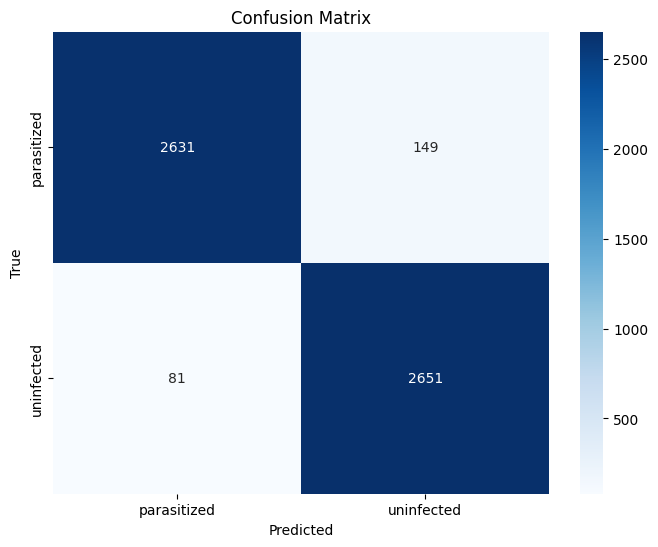

              precision    recall  f1-score   support

 parasitized       0.97      0.95      0.96      2780
  uninfected       0.95      0.97      0.96      2732

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



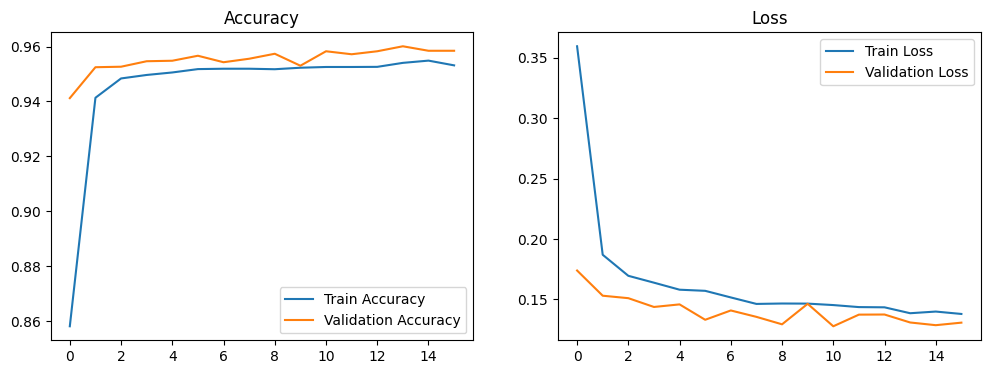

In [ ]:
# TensorFlow/Keras da
loss, accuracy, precision, recall = model_custom.evaluate(val_dataset) # Yoki test_dataset
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")

# Chalkashlik matritsasi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred_probs = model_custom.predict(val_dataset)
y_pred = (y_pred_probs > 0.5).astype(int).flatten() # Threshold 0.5

# Haqiqiy yorliqlarni olish
y_true = []
for images, labels in val_dataset.unbatch().take(-1): # Barcha elementlarni olish
    y_true.append(labels.numpy())
y_true = np.array(y_true)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ds_info.features['label'].names,
            yticklabels=ds_info.features['label'].names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=ds_info.features['label'].names))

# O'qitish tarixini vizualizatsiya qilish
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
# TensorFlow/Keras da
model_custom.save('malarisdfga_cnn_model_final.h5')
# Yuklab olish uchun
from google.colab import files
files.download('malarisdfga_cnn_model_final.h5')